<a href="https://colab.research.google.com/github/dnth/zenml-optuna/blob/master/pytorch_hpo_fmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install zenml[server] optuna optuna-dashboard plotly

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(restart=True)

In [ ]:
!rm -rf .zen
!zenml init

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim


from zenml.pipelines import pipeline
from zenml.steps import step, Output, BaseParameters

import optuna
from optuna.trial import TrialState
from optuna.storages import RetryFailedTrialCallback

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
@pipeline
def pytorch_hpo_pipeline(
    load_data,
    run_hpo,
    train_test,
):
    """A `pipeline` to load data, load model, and train/evaluate the model."""
    train_dataloader, test_dataloader = load_data()
    best_hparams = run_hpo(train_dataloader, test_dataloader)
    train_test(best_hparams, train_dataloader, test_dataloader)

In [3]:
@step
def load_data() -> Output(train_dataloader=DataLoader, test_dataloader=DataLoader):
    """A `step` to load the Fashion MNIST dataset as a tuple of torch Datasets."""

    batch_size = 64

    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, test_dataloader

In [4]:
def define_hpo_model(trial, hpo_params):
    CLASSES = 10
    n_layers = trial.suggest_int(
        "n_layers", hpo_params.n_layers_low, hpo_params.n_layers_high
    )
    layers = []
    in_features = 28 * 28
    layers.append(nn.Flatten())

    for i in range(n_layers):
        out_features = trial.suggest_int(
            f"n_units_l{i}", hpo_params.hidden_unit_low, hpo_params.hidden_unit_high
        )
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float(
            f"dropout_l{i}", hpo_params.dropout_p_low, hpo_params.dropout_p_high
        )
        layers.append(nn.Dropout(p))
        in_features = out_features

    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def objective(trial, train_dataloader, test_dataloader, hpo_params):

    # Generate model
    model = define_hpo_model(trial, hpo_params)

    # Train model
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical(
        "optimizer_name", hpo_params.optimizer_choices
    )
    lr = trial.suggest_float("lr", hpo_params.lr_low, hpo_params.lr_high, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    size = len(train_dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_accuracy = 100 * correct
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

    return test_accuracy


class HPOParams(BaseParameters):
    """Optuna Study Params"""

    n_trials: int
    timeout: int
    direction: str
    study_name: str
    sqlite_db_name: str

    optimizer_choices: list
    lr_low: float
    lr_high: float

    n_layers_low: int
    n_layers_high: int

    hidden_unit_low: int
    hidden_unit_high: int

    dropout_p_low: float
    dropout_p_high: float


@step
def run_hpo(
    hpo_params: HPOParams, train_dataloader: DataLoader, test_dataloader: DataLoader
) -> dict:

    storage = optuna.storages.RDBStorage(
        hpo_params.sqlite_db_name,
        heartbeat_interval=1,
        failed_trial_callback=RetryFailedTrialCallback(),
    )

    study = optuna.create_study(
        study_name=hpo_params.study_name,
        direction=hpo_params.direction,
        storage=storage,
    )
    study.optimize(
        lambda trial: objective(
            trial, train_dataloader, test_dataloader, hpo_params=hpo_params
        ),
        n_trials=hpo_params.n_trials,
        timeout=hpo_params.timeout,
    )

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best = trial.params

    print("Found best hyperparam dict from optimization work!")
    print(best)

    return best

In [5]:
def define_model(hparam: dict):
    CLASSES = 10
    layers = []
    in_features = 28 * 28
    layers.append(nn.Flatten())

    print(hparam)

    for i in range(hparam["n_layers"]):
        out_features = hparam[f"n_units_l{i}"]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = hparam[f"dropout_l{i}"]
        layers.append(nn.Dropout(p))
        in_features = out_features

    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    """A function to train a model for one epoch."""
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    """A function to test a model on the validation / test dataset."""
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_accuracy = 100 * correct
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

    return test_accuracy

In [7]:
@step
def train_test(
    best_hparams: dict, train_dataloader: DataLoader, test_dataloader: DataLoader
) -> Output(trained_model=nn.Module, test_acc=float):
    """A `step` to train and evaluate a torch model on given dataloaders."""

    epochs = 5

    model = define_model(best_hparams)

    print("Constructing optimized model:")
    print(model)

    print("Using optimized hyperparams")
    print(best_hparams)

    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    lr = best_hparams["lr"]
    optimizer_name = best_hparams["optimizer_name"]
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    test_acc = 0
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_acc = test(test_dataloader, model, loss_fn)
    print("Done!")

    return model, test_acc

In [24]:
pytorch_hpo_pipeline(
    load_data=load_data(),
    run_hpo=run_hpo(
        hpo_params=HPOParams(
            n_trials=30,
            timeout=300,
            direction="maximize",
            study_name="zenml-optuna-hpo",
            sqlite_db_name="sqlite:///zenml-optuna.db",
            optimizer_choices=["Adam", "SGD", "RMSprop"],
            lr_low=1e-5,
            lr_high=1e-1,
            n_layers_low=1,
            n_layers_high=5,
            hidden_unit_low=8,
            hidden_unit_high=128,
            dropout_p_low=0.1,
            dropout_p_high=0.5,
        ),
    ),
    train_test=train_test(),
).run(unlisted=True)

Running unlisted pipeline on stack default (caching enabled)
Step load_data has started.
Using cached version of load_data.
Step load_data has finished in 0.016s.
Step run_hpo has started.


/tmp/ipykernel_69972/1732787293.py:97: ExperimentalWarning:

RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.

[I 2022-11-29 14:00:51,583] A new study created in RDB with name: zenml-optuna-hpo
/home/dnth/anaconda3/envs/zenml-hpo/lib/python3.8/site-packages/optuna/study/_optimize.py:185: ExperimentalWarning:

fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.

[I 2022-11-29 14:00:56,856] Trial 0 finished with value: 60.019999999999996 and parameters: {'n_layers': 1, 'n_units_l0': 46, 'dropout_l0': 0.28570637838799695, 'optimizer_name': 'SGD', 'lr': 0.0016028145179606984}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 60.0%, Avg loss: 1.736425 



[I 2022-11-29 14:01:01,885] Trial 1 finished with value: 10.0 and parameters: {'n_layers': 5, 'n_units_l0': 115, 'dropout_l0': 0.1520042393228633, 'n_units_l1': 8, 'dropout_l1': 0.34131471853144335, 'n_units_l2': 53, 'dropout_l2': 0.12444949736186661, 'n_units_l3': 113, 'dropout_l3': 0.25476739019387085, 'n_units_l4': 65, 'dropout_l4': 0.1602869096628317, 'optimizer_name': 'SGD', 'lr': 0.0006696317373710126}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 10.0%, Avg loss: 2.306660 



[I 2022-11-29 14:01:06,827] Trial 2 finished with value: 10.0 and parameters: {'n_layers': 5, 'n_units_l0': 82, 'dropout_l0': 0.2582687268541006, 'n_units_l1': 104, 'dropout_l1': 0.33586722897812227, 'n_units_l2': 59, 'dropout_l2': 0.24998686140106074, 'n_units_l3': 98, 'dropout_l3': 0.45714593926678004, 'n_units_l4': 12, 'dropout_l4': 0.2249759685303314, 'optimizer_name': 'SGD', 'lr': 3.0389248961238337e-05}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 10.0%, Avg loss: 2.319824 



[I 2022-11-29 14:01:11,566] Trial 3 finished with value: 10.0 and parameters: {'n_layers': 2, 'n_units_l0': 18, 'dropout_l0': 0.2816778805685412, 'n_units_l1': 105, 'dropout_l1': 0.16752177433751259, 'optimizer_name': 'RMSprop', 'lr': 0.018651494046404867}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 10.0%, Avg loss: 2.309801 



[I 2022-11-29 14:01:16,962] Trial 4 finished with value: 38.12 and parameters: {'n_layers': 5, 'n_units_l0': 123, 'dropout_l0': 0.1582708888345219, 'n_units_l1': 46, 'dropout_l1': 0.2915599419988555, 'n_units_l2': 16, 'dropout_l2': 0.417810691542178, 'n_units_l3': 35, 'dropout_l3': 0.1631897003624058, 'n_units_l4': 16, 'dropout_l4': 0.41590810511053855, 'optimizer_name': 'Adam', 'lr': 7.315679304237704e-05}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 38.1%, Avg loss: 1.729215 



[I 2022-11-29 14:01:22,058] Trial 5 finished with value: 10.0 and parameters: {'n_layers': 5, 'n_units_l0': 117, 'dropout_l0': 0.4838379968290675, 'n_units_l1': 53, 'dropout_l1': 0.37458638368856134, 'n_units_l2': 112, 'dropout_l2': 0.37200100971825223, 'n_units_l3': 67, 'dropout_l3': 0.4356594096960027, 'n_units_l4': 19, 'dropout_l4': 0.17210469992658012, 'optimizer_name': 'SGD', 'lr': 0.000538098556700634}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 10.0%, Avg loss: 2.309454 



[I 2022-11-29 14:01:27,173] Trial 6 finished with value: 37.63 and parameters: {'n_layers': 3, 'n_units_l0': 90, 'dropout_l0': 0.25617162412972283, 'n_units_l1': 39, 'dropout_l1': 0.3699557627180129, 'n_units_l2': 58, 'dropout_l2': 0.3771039669922559, 'optimizer_name': 'Adam', 'lr': 0.04319035151248827}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 37.6%, Avg loss: 1.632238 



[I 2022-11-29 14:01:32,636] Trial 7 finished with value: 10.0 and parameters: {'n_layers': 4, 'n_units_l0': 107, 'dropout_l0': 0.42019275493507935, 'n_units_l1': 18, 'dropout_l1': 0.26326127099956786, 'n_units_l2': 85, 'dropout_l2': 0.3986768732915036, 'n_units_l3': 23, 'dropout_l3': 0.49347909729318096, 'optimizer_name': 'Adam', 'lr': 0.04318226696423746}. Best is trial 0 with value: 60.019999999999996.


Test Error: 
 Accuracy: 10.0%, Avg loss: 2.306859 



[I 2022-11-29 14:01:38,053] Trial 8 finished with value: 79.9 and parameters: {'n_layers': 4, 'n_units_l0': 76, 'dropout_l0': 0.35591378714546407, 'n_units_l1': 57, 'dropout_l1': 0.11449442747011772, 'n_units_l2': 118, 'dropout_l2': 0.19088107876417154, 'n_units_l3': 107, 'dropout_l3': 0.4236082163682823, 'optimizer_name': 'Adam', 'lr': 0.0016765663633728865}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 79.9%, Avg loss: 0.517894 



[I 2022-11-29 14:01:42,624] Trial 9 finished with value: 40.5 and parameters: {'n_layers': 2, 'n_units_l0': 33, 'dropout_l0': 0.12866913351677534, 'n_units_l1': 82, 'dropout_l1': 0.34687892104243867, 'optimizer_name': 'SGD', 'lr': 0.0026454734792198723}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 40.5%, Avg loss: 1.904105 



[I 2022-11-29 14:01:47,625] Trial 10 finished with value: 69.01 and parameters: {'n_layers': 3, 'n_units_l0': 62, 'dropout_l0': 0.39121486820979434, 'n_units_l1': 77, 'dropout_l1': 0.4837698871470333, 'n_units_l2': 125, 'dropout_l2': 0.19022969455372946, 'optimizer_name': 'RMSprop', 'lr': 0.006332167504515996}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 69.0%, Avg loss: 0.758990 



[I 2022-11-29 14:01:52,689] Trial 11 finished with value: 72.66 and parameters: {'n_layers': 3, 'n_units_l0': 61, 'dropout_l0': 0.3815920475691965, 'n_units_l1': 78, 'dropout_l1': 0.4808285890082648, 'n_units_l2': 124, 'dropout_l2': 0.17637186121346404, 'optimizer_name': 'RMSprop', 'lr': 0.006926797064113372}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 72.7%, Avg loss: 0.760077 



[I 2022-11-29 14:01:57,949] Trial 12 finished with value: 73.88 and parameters: {'n_layers': 4, 'n_units_l0': 65, 'dropout_l0': 0.390897820886151, 'n_units_l1': 126, 'dropout_l1': 0.10939684912840239, 'n_units_l2': 98, 'dropout_l2': 0.1036846487930315, 'n_units_l3': 128, 'dropout_l3': 0.3483094390092136, 'optimizer_name': 'RMSprop', 'lr': 0.00020172540507310045}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 73.9%, Avg loss: 0.677502 



[I 2022-11-29 14:02:03,141] Trial 13 finished with value: 74.89 and parameters: {'n_layers': 4, 'n_units_l0': 81, 'dropout_l0': 0.3550885285395573, 'n_units_l1': 127, 'dropout_l1': 0.12878518614756507, 'n_units_l2': 94, 'dropout_l2': 0.10354384217951071, 'n_units_l3': 128, 'dropout_l3': 0.35261446419301085, 'optimizer_name': 'RMSprop', 'lr': 0.00016839404323743475}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 74.9%, Avg loss: 0.668780 



[I 2022-11-29 14:02:08,621] Trial 14 finished with value: 33.12 and parameters: {'n_layers': 4, 'n_units_l0': 89, 'dropout_l0': 0.3404763007124277, 'n_units_l1': 126, 'dropout_l1': 0.18346452522991358, 'n_units_l2': 89, 'dropout_l2': 0.2753344206939803, 'n_units_l3': 90, 'dropout_l3': 0.3560615383146486, 'optimizer_name': 'Adam', 'lr': 1.572634764285446e-05}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 33.1%, Avg loss: 1.759312 



[I 2022-11-29 14:02:14,131] Trial 15 finished with value: 73.67 and parameters: {'n_layers': 4, 'n_units_l0': 80, 'dropout_l0': 0.4645176817050012, 'n_units_l1': 61, 'dropout_l1': 0.102287996906607, 'n_units_l2': 103, 'dropout_l2': 0.1915167139513256, 'n_units_l3': 120, 'dropout_l3': 0.3825464924265315, 'optimizer_name': 'Adam', 'lr': 0.000191900748908385}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.697942 



[I 2022-11-29 14:02:19,395] Trial 16 finished with value: 75.06 and parameters: {'n_layers': 4, 'n_units_l0': 100, 'dropout_l0': 0.21564796881245163, 'n_units_l1': 32, 'dropout_l1': 0.1829838920168933, 'n_units_l2': 78, 'dropout_l2': 0.13886405241223246, 'n_units_l3': 71, 'dropout_l3': 0.2862450153910333, 'optimizer_name': 'RMSprop', 'lr': 0.00020226386128438745}. Best is trial 8 with value: 79.9.


Test Error: 
 Accuracy: 75.1%, Avg loss: 0.683776 



[I 2022-11-29 14:02:24,491] Trial 17 finished with value: 81.82000000000001 and parameters: {'n_layers': 2, 'n_units_l0': 98, 'dropout_l0': 0.1971842319188308, 'n_units_l1': 30, 'dropout_l1': 0.2089136753111981, 'optimizer_name': 'Adam', 'lr': 0.0005160008406688469}. Best is trial 17 with value: 81.82000000000001.


Test Error: 
 Accuracy: 81.8%, Avg loss: 0.507788 



[I 2022-11-29 14:02:29,512] Trial 18 finished with value: 82.23 and parameters: {'n_layers': 2, 'n_units_l0': 49, 'dropout_l0': 0.21398845747805642, 'n_units_l1': 27, 'dropout_l1': 0.2303090465275584, 'optimizer_name': 'Adam', 'lr': 0.004055926863298621}. Best is trial 18 with value: 82.23.


Test Error: 
 Accuracy: 82.2%, Avg loss: 0.489335 



[I 2022-11-29 14:02:34,332] Trial 19 finished with value: 82.71 and parameters: {'n_layers': 1, 'n_units_l0': 44, 'dropout_l0': 0.19716258997078334, 'optimizer_name': 'Adam', 'lr': 0.005872235313444498}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.474020 



[I 2022-11-29 14:02:39,306] Trial 20 finished with value: 82.61 and parameters: {'n_layers': 1, 'n_units_l0': 46, 'dropout_l0': 0.21183071154732694, 'optimizer_name': 'Adam', 'lr': 0.007523355666925934}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 82.6%, Avg loss: 0.476165 



[I 2022-11-29 14:02:44,136] Trial 21 finished with value: 82.34 and parameters: {'n_layers': 1, 'n_units_l0': 42, 'dropout_l0': 0.20665077813288377, 'optimizer_name': 'Adam', 'lr': 0.007049184719607572}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 82.3%, Avg loss: 0.483017 



[I 2022-11-29 14:02:48,807] Trial 22 finished with value: 81.5 and parameters: {'n_layers': 1, 'n_units_l0': 29, 'dropout_l0': 0.18380987990707368, 'optimizer_name': 'Adam', 'lr': 0.015537933683780758}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 81.5%, Avg loss: 0.514516 



[I 2022-11-29 14:02:53,597] Trial 23 finished with value: 79.9 and parameters: {'n_layers': 1, 'n_units_l0': 46, 'dropout_l0': 0.2371141188870007, 'optimizer_name': 'Adam', 'lr': 0.01492951212451621}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 79.9%, Avg loss: 0.543593 



[I 2022-11-29 14:02:58,433] Trial 24 finished with value: 82.34 and parameters: {'n_layers': 1, 'n_units_l0': 33, 'dropout_l0': 0.1103248682054903, 'optimizer_name': 'Adam', 'lr': 0.0077466910679147}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 82.3%, Avg loss: 0.485638 



[I 2022-11-29 14:03:03,113] Trial 25 finished with value: 75.59 and parameters: {'n_layers': 1, 'n_units_l0': 8, 'dropout_l0': 0.11079204282698599, 'optimizer_name': 'Adam', 'lr': 0.017042092459538923}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.663072 



[I 2022-11-29 14:03:08,463] Trial 26 finished with value: 31.61 and parameters: {'n_layers': 2, 'n_units_l0': 56, 'dropout_l0': 0.167540474992606, 'n_units_l1': 97, 'dropout_l1': 0.43877238037857463, 'optimizer_name': 'Adam', 'lr': 0.06319168396099625}. Best is trial 19 with value: 82.71.


Test Error: 
 Accuracy: 31.6%, Avg loss: 1.784367 



[I 2022-11-29 14:03:13,398] Trial 27 finished with value: 82.86 and parameters: {'n_layers': 1, 'n_units_l0': 33, 'dropout_l0': 0.10529664327303556, 'optimizer_name': 'Adam', 'lr': 0.0033462715449857072}. Best is trial 27 with value: 82.86.


Test Error: 
 Accuracy: 82.9%, Avg loss: 0.459815 



[I 2022-11-29 14:03:18,107] Trial 28 finished with value: 84.15 and parameters: {'n_layers': 1, 'n_units_l0': 25, 'dropout_l0': 0.13406863193165305, 'optimizer_name': 'Adam', 'lr': 0.0026586602311428537}. Best is trial 28 with value: 84.15.


Test Error: 
 Accuracy: 84.2%, Avg loss: 0.454946 



[I 2022-11-29 14:03:22,870] Trial 29 finished with value: 82.44 and parameters: {'n_layers': 1, 'n_units_l0': 23, 'dropout_l0': 0.13425122150241958, 'optimizer_name': 'Adam', 'lr': 0.0012157041764616727}. Best is trial 28 with value: 84.15.


Test Error: 
 Accuracy: 82.4%, Avg loss: 0.494390 

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  84.15
  Params: 
    dropout_l0: 0.13406863193165305
    lr: 0.0026586602311428537
    n_layers: 1
    n_units_l0: 25
    optimizer_name: Adam
Found best hyperparam dict from optimization work!
{'dropout_l0': 0.13406863193165305, 'lr': 0.0026586602311428537, 'n_layers': 1, 'n_units_l0': 25, 'optimizer_name': 'Adam'}
Step run_hpo has finished in 2m31s.
Step train_test has started.
{'dropout_l0': 0.13406863193165305, 'lr': 0.0026586602311428537, 'n_layers': 1, 'n_units_l0': 25, 'optimizer_name': 'Adam'}
Constructing optimized model:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=25, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.13406863193165305, inplace=False)
  (4): Linear(in_features=25, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Using optim

In [25]:
import optuna
from optuna.storages import RetryFailedTrialCallback

storage = optuna.storages.RDBStorage(
    "sqlite:///zenml-optuna.db",
    heartbeat_interval=1,
    failed_trial_callback=RetryFailedTrialCallback(),
)

study = optuna.load_study(study_name="zenml-optuna-hpo", storage=storage)

/tmp/ipykernel_69972/2206632645.py:7: ExperimentalWarning:

RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.



In [26]:
# importing all the plot functions
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

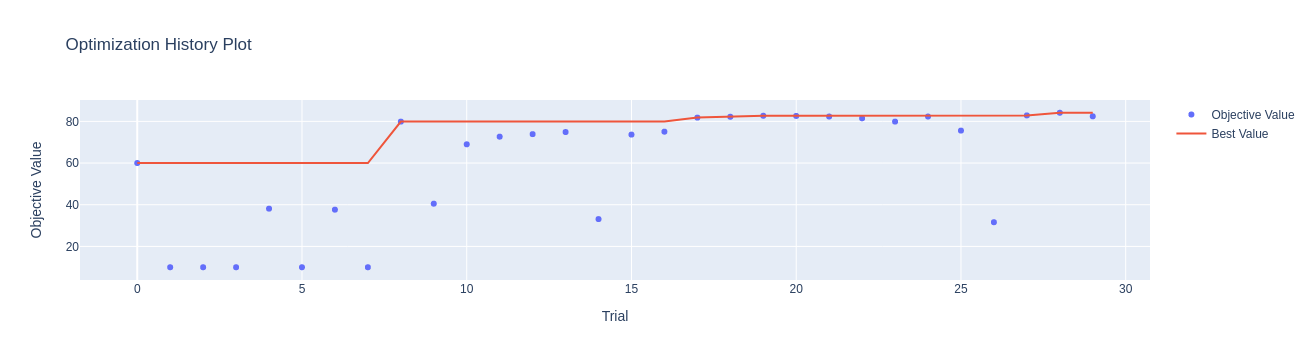

In [27]:
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

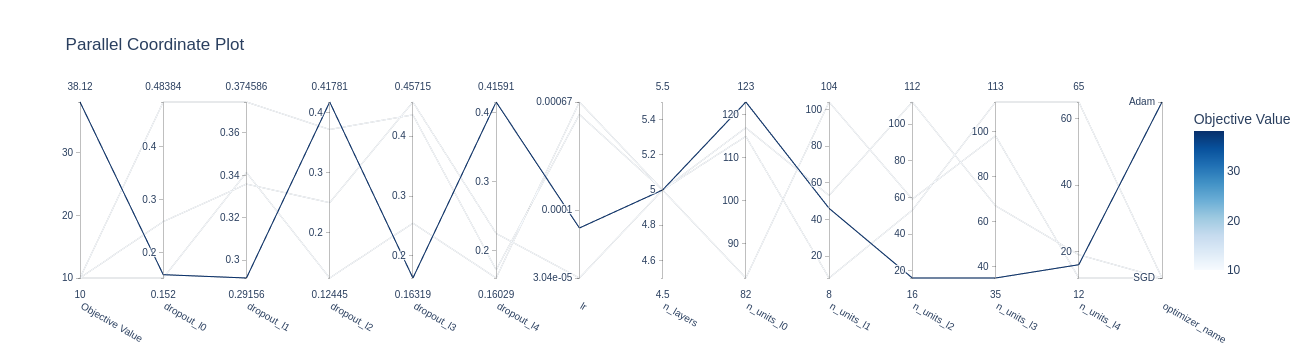

In [28]:
# Visualize high-dimensional parameter relationships. See :func:`~optuna.visualization.plot_parallel_coordinate` for the details.
plot_parallel_coordinate(study)

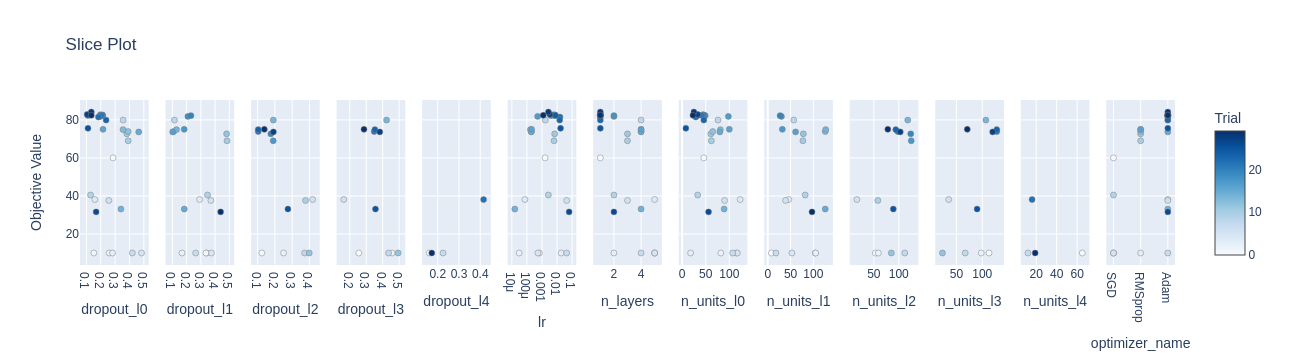

In [29]:
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study)

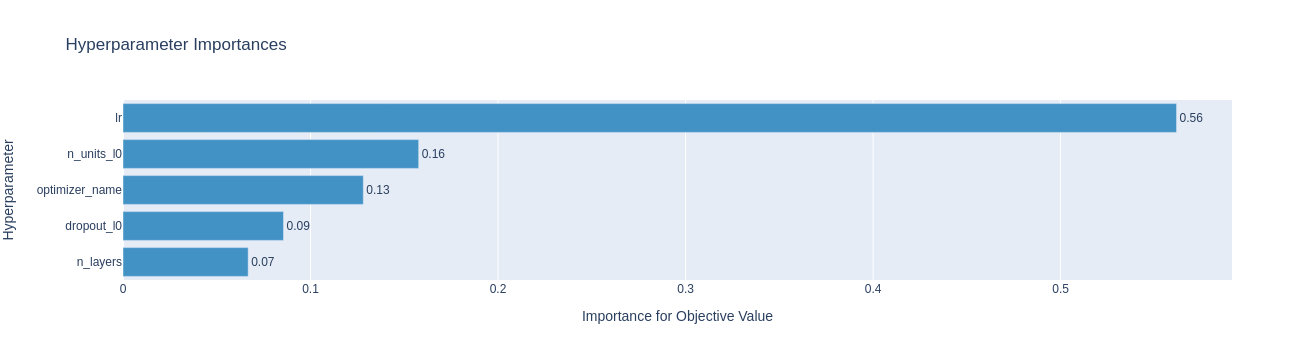

In [30]:
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
# In this case, we have only one parameter.
plot_param_importances(study)

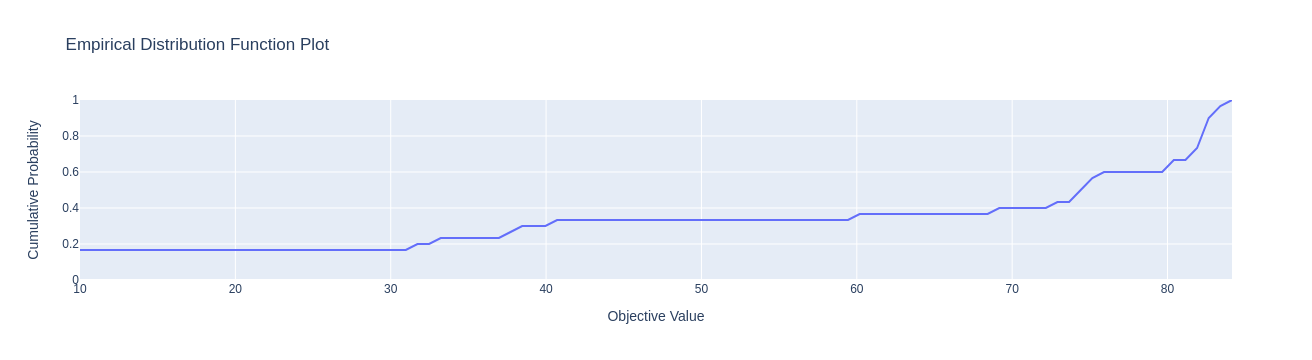

In [31]:
# Visualize empirical distribution function. See :func:`~optuna.visualization.plot_edf` for the details.
plot_edf(study)